In [3]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

[(10, 30,    937, 1) (33, 20,   1030, 1) (12, 27,   1052, 1) ...
 ( 7, 15, 302706, 1) (26, 11, 303852, 1) (11, 17, 305341, 1)]


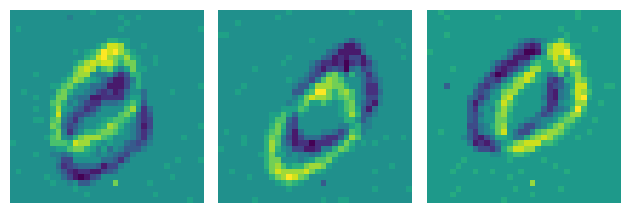

In [4]:
tonic.utils.plot_event_grid(events)

In [5]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, 
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

1011894272it [02:03, 8219360.21it/s]                                 


Extracting ./tmp/data/NMNIST/train.zip to ./tmp/data/NMNIST


169675776it [00:21, 7786681.10it/s]                                


Extracting ./tmp/data/NMNIST/test.zip to ./tmp/data/NMNIST


In [6]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [7]:
%timeit -o load_sample_simple()

602 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 602 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [8]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [9]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [10]:
%timeit -o -r 10 load_sample_batched()

1.53 ms ± 46.4 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


<TimeitResult : 1.53 ms ± 46.4 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)>

In [11]:
from tonic import MemoryCachedDataset

cached_trainset = MemoryCachedDataset(trainset)

In [ ]:
#train1
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [13]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([310, 128, 2, 34, 34])


In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [ ]:
# this time, we won't return membrane as we don't need it 

def forward_pass(net, data):  
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)